In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

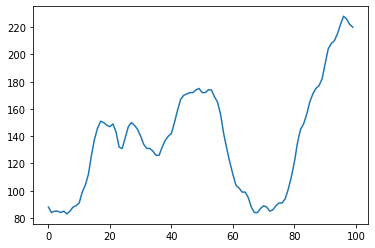

In [3]:
plt.plot(df.value)

In [4]:
df.value[:10].mean(),df.value[:10].std()

(85.6, 2.0110804171997807)

In [5]:
df.value[10:20].mean(),df.value[10:20].std()

(126.5, 23.2390954117314)

In [6]:
df.value[20:30].mean(),df.value[20:30].std()

(143.1, 6.887186169498639)

In [7]:
from statsmodels.tsa.stattools import adfuller
adfuller(df.value)

(-2.4642397172033688,
 0.12441935447109453,
 3,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 444.67104090432554)

In [8]:
def adfuller_test(val):
    
    result = adfuller(val)
    
    labels = ['ADF Test Statistic','p-value','Lags','Number of Observations Used']
    
    for value,label in zip(result,labels):
        
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(df.value)

ADF Test Statistic : -2.4642397172033688
p-value : 0.12441935447109453
Lags : 3
Number of Observations Used : 96
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [9]:
df['1st Differencing'] = df.value - df.value.shift(1)

adfuller_test(df['1st Differencing'].dropna())

ADF Test Statistic : -2.7222384904429533
p-value : 0.07026846015272693
Lags : 2
Number of Observations Used : 96
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
df['2nd Differencing'] = df['1st Differencing'] - df['1st Differencing'].shift(1)
adfuller_test(df['2nd Differencing'].dropna())

ADF Test Statistic : -9.929762173626015
p-value : 2.843428755547158e-17
Lags : 1
Number of Observations Used : 96
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [11]:
df['3rd Differencing'] = df['2nd Differencing'] - df['2nd Differencing'].shift(1)
adfuller_test(df['3rd Differencing'].dropna())

ADF Test Statistic : -6.266019534385489
p-value : 4.112279771510164e-08
Lags : 10
Number of Observations Used : 86
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [12]:
df['4th Differencing'] = df['3rd Differencing'] - df['3rd Differencing'].shift(1)
adfuller_test(df['4th Differencing'].dropna())

ADF Test Statistic : -6.779440732659457
p-value : 2.521371491786434e-09
Lags : 12
Number of Observations Used : 83
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


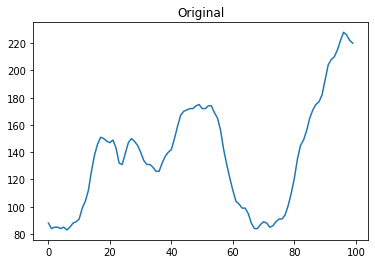

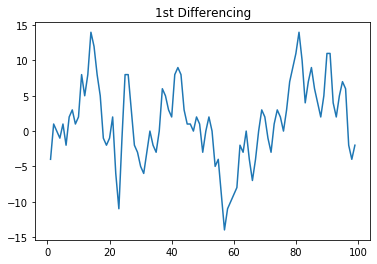

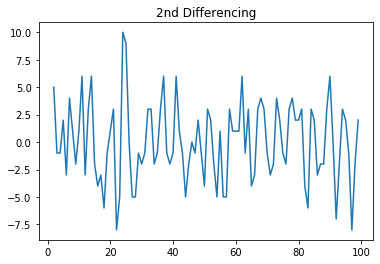

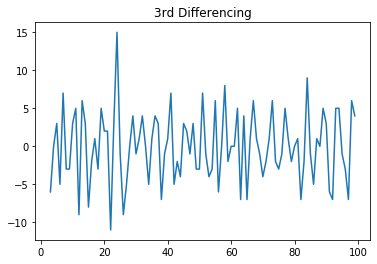

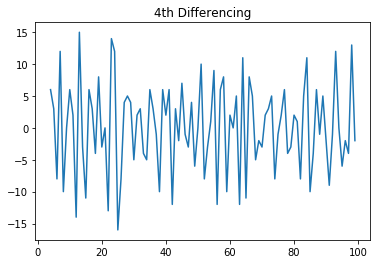

In [13]:
plt.plot(df.value)
plt.title('Original')
plt.show()

plt.plot(df['1st Differencing'].dropna())
plt.title('1st Differencing')
plt.show()

plt.plot(df['2nd Differencing'].dropna())
plt.title('2nd Differencing')
plt.show()

plt.plot(df['3rd Differencing'].dropna())
plt.title('3rd Differencing')
plt.show()

plt.plot(df['4th Differencing'].dropna())
plt.title('4th Differencing')
plt.show()

C:\Users\Mickey\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


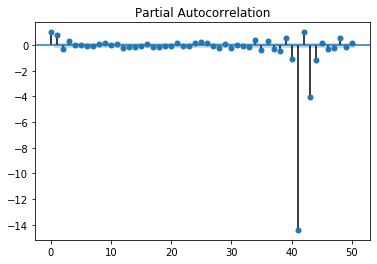

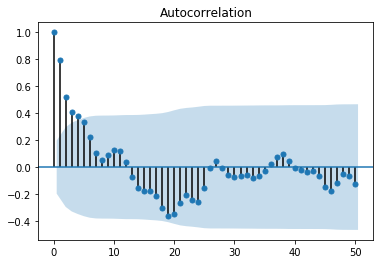

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_pacf(df['1st Differencing'].dropna(), lags=50)
plot_acf(df['1st Differencing'].dropna(), lags=50)
plt.show()

In [15]:
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

X = df.value
train = df['1st Differencing'][1:80]
test  = df['1st Differencing'][80:]

df_perf = []
for i in range(5):
    for j in range(1):
        model = ARMA(train.dropna(), order=(i, j)).fit()
        #preds = model.predict(89,98)
        predictions = model.predict(start=len(train), end=len(train)+len(test)-1)
        df_perf.append([i,j,mean_squared_error(test, predictions),mean_absolute_error(test, predictions)])
        
pd.DataFrame(df_perf,columns = ['AR (p)','MA (q)','MSE','MAE'])

,AR (p),MA (q),MSE,MAE
0,0,0,49.014261,6.105063
1,1,0,27.108587,4.464686
2,2,0,36.182451,5.342908
3,3,0,30.573764,4.774112
4,4,0,31.274551,4.851677


In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       1st Differencing   No. Observations:                   79
Model:                     ARMA(4, 0)   Log Likelihood                -202.181
Method:                       css-mle   S.D. of innovations              3.101
Date:                Mon, 27 Apr 2020   AIC                            416.363
Time:                        16:20:37   BIC                            430.580
Sample:                             0   HQIC                           422.058
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3708      1.546      0.240      0.810      -2.659       3.400
ar.L1.1st Differencing     1.1165      0.114      9.781      0.000       0.893       1.340
ar.L2.1st Differencing    -0.6029      0.168     -3.593      0.000      -0.932      -0.274
ar.L3.1st Differencing     0.3114      0.167      1.864      0.062      -0.016       0.639
ar.L4.1st Differencing    -0.0426      0.114     -0.375      0.708      -0.265       0.180
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3066           -0.0000j            1.3066           -0.0000
AR.2            0.2765           -1.7942j            1.8154           -0.2257
AR.3            0.2765           +1.7942j            1.8154            0.2257
AR.4            5.4545           -0.0000j            5.4545           -0.0000
-----------------------------------------------------------------------------
"""

In [17]:
model = ARMA(train.dropna(), order=(1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       1st Differencing   No. Observations:                   79
Model:                     ARMA(1, 0)   Log Likelihood                -208.783
Method:                       css-mle   S.D. of innovations              3.380
Date:                Mon, 27 Apr 2020   AIC                            423.566
Time:                        16:20:40   BIC                            430.674
Sample:                             0   HQIC                           426.414
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4652      1.685      0.276      0.782      -2.837       3.767
ar.L1.1st Differencing     0.7838      0.070     11.152      0.000       0.646       0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2758           +0.0000j            1.2758            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
undiffpreds = pd.concat([pd.Series(df['value'][0]),pd.Series(train.values),predictions]).cumsum().tail(15)

In [21]:
undiffpreds

84    131.640460
85    133.102290
86    134.324130
87    135.359957
88    136.237186
89    136.991019
90    137.654995
91    138.251581
92    138.795428
93    139.298299
94    139.770057
95    140.218230
96    140.648316
97    141.064482
98    141.469994
dtype: float64

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [25]:
model = ARIMA(df.value, order = (4,1,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -251.790
Method:                       css-mle   S.D. of innovations              3.054
Date:                Mon, 27 Apr 2020   AIC                            515.580
Time:                        16:25:19   BIC                            531.151
Sample:                             1   HQIC                           521.880
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9886      1.612      0.613      0.540      -2.170       4.147
ar.L1.D.value     1.1561      0.101     11.399      0.000       0.957       1.355
ar.L2.D.value    -0.6789      0.151     -4.496      0.000      -0.975      -0.383
ar.L3.D.value     0.3692      0.152      2.431      0.015       0.072       0.667
ar.L4.D.value    -0.0299      0.103     -0.291      0.771      -0.231       0.171
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2155           -0.0000j            1.2155           -0.0000
AR.2            0.3120           -1.5876j            1.6180           -0.2191
AR.3            0.3120           +1.5876j            1.6180            0.2191
AR.4           10.5236           -0.0000j           10.5236           -0.0000
-----------------------------------------------------------------------------
"""

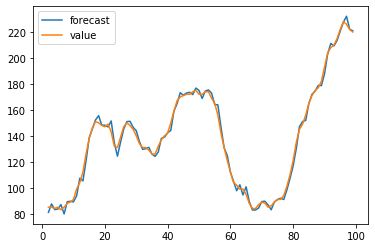

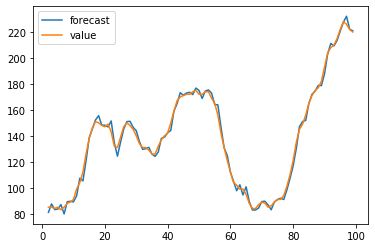

In [26]:
model.plot_predict()

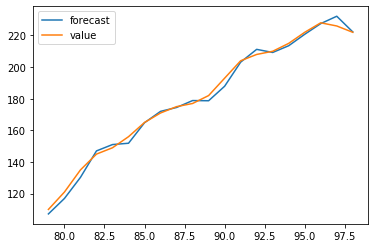

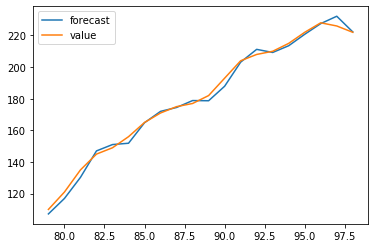

In [30]:
model.plot_predict(79,98)

In [31]:
preds, err, conf = model.forecast(15)

In [32]:
preds

array([219.66743957, 219.40522996, 218.89038492, 218.59158823,
       218.69026065, 219.00638555, 219.39135667, 219.84857476,
       220.4109863 , 221.06488283, 221.7777413 , 222.53333154,
       223.32892614, 224.16079331, 225.02144971])

In [34]:
err

array([ 3.05412704,  7.2587202 , 11.24871258, 14.81785769, 18.28355625,
       21.79540944, 25.27722471, 28.64041855, 31.87479585, 35.00039793,
       38.02397795, 40.94198547, 43.75468592, 46.4679094 , 49.08817969])

In [35]:
conf

array([[213.68146057, 225.65341857],
       [205.1783998 , 233.63206013],
       [196.84331338, 240.93745645],
       [189.54912082, 247.63405563],
       [182.85514889, 254.52537242],
       [176.28816802, 261.72460308],
       [169.8489066 , 268.93380673],
       [163.71438589, 275.98276363],
       [157.93753443, 282.88443817],
       [152.46536345, 289.66440222],
       [147.25211396, 296.30336864],
       [142.28851455, 302.77814852],
       [137.57131759, 309.08653469],
       [133.08536444, 315.23622218],
       [128.81038545, 321.23251396]])